<a href="https://colab.research.google.com/github/Bibhash123/JSTARS-NESNet/blob/main/Proposed_Method/SO2_and_O3_Ireland.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
from google.colab import files
_ = files.upload()
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d bibhash123/so2estimation
!unzip so2estimation.zip -d "/content/SO2dataset"
!rm so2estimation.zip

!kaggle datasets download -d bibhash123/o3estimation
!unzip o3estimation.zip -d "/content/O3dataset"
!rm o3estimation.zip
from IPython.display import clear_output
clear_output(wait=False)

In [ ]:
!pip uninstall -y shapely
!pip uninstall -y cartopy
!pip install shapely cartopy --no-binary shapely --no-binary cartopy
clear_output(wait=False)

In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import os
import gc
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import utils

SEED=123
def seedAll(seed):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ["PYTHONHASHSEED"]=str(seed)

seedAll(SEED)

In [ ]:
def pearson(y_true,y_pred):
  if len(y_true.shape)!=1:
    true = []
    for i in range(y_true.shape[0]):
      true.extend(y_true[i])
    pred = []
    for i in range(y_pred.shape[0]):
      pred.extend(y_pred[i])
  else:
    true=y_true
    pred=y_pred
  return np.mean((np.array(true)-np.mean(true))*(np.array(pred)-np.mean(pred)))/(np.std(np.array(true))*np.std(np.array(pred)))

def pearsonCorrAvgDays(true,pred):
  # assert len(true.shape)>=3,"true must have at least 3 dimensions, found {}".format(len(true.shape))
  assert true.shape==pred.shape, "true and pred must have same shape, found {} and {}".format(true.shape,pred.shape)
  scores = []
  for i in range(true.shape[0]):
    scores.append(pearson(true[i],pred[i]))
  return np.mean(scores),scores

def pearsonCorrAvgPixels(true,pred):
  scores = []
  for i in range(true.shape[1]):
    scores.append(pearson(true[:,i],pred[:,i]))
  return np.mean(scores),scores

# SO<sub>2</sub>

In [ ]:
files = pd.read_csv("/content/SO2dataset/files.csv").sample(frac=1).reset_index(drop=True)

In [ ]:
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=5,shuffle=True)
# files.loc[:,'Fold'] = -1

# for fold,(i_trn,i_val) in enumerate(kf.split(files)):
#   files.loc[i_val,"Fold"] = fold

# files.to_csv("files.csv",index=False)
# !rm -r "/content/SO2dataset/files.csv"
# !cp "files.csv" "/content/SO2dataset/files.csv"
# !kaggle datasets init -p "/content/SO2dataset"
# _ = input("Press any Key to continue")
# !kaggle datasets version -p "/content/SO2dataset" --dir-mode tar -m "Update"
# # train_files,val_files = train_test_split(files,test_size=0.2)

### Univariate

In [ ]:
def loadData(df,satdir = "/content/dataset/satellite/",gdir = "/content/dataset/ground/"):
  X = []
  Y = []
  for i in range(df.shape[0]):
    factor = 46*(6.02214/6.023)*1e2
    sat = np.expand_dims(factor*np.load(os.path.join(satdir,df["SatFile"].iloc[i])),axis=2)      
    ground = np.load(os.path.join(gdir,df["GroundFile"].iloc[i])).flatten()
    if not np.isnan(np.sum(sat)) and not np.isnan(np.sum(ground)):
      if not np.std(ground)==0:
        X.append(sat)
        Y.append(ground)
  return np.stack(X,axis=0),np.stack(Y,axis=0)

In [ ]:
# def build_model(X_train):
#   inp = L.Input(shape=X_train[0].shape)
#   h = L.Conv2D(16,(3,3),activation="linear",padding="same")(inp)
#   h = L.Conv2D(16,(3,3),activation="linear")(h)
#   h = L.Conv2D(32,(3,3),activation="linear")(h)
#   out = L.Flatten()(h)
#   out = L.Dense(100,activation="linear")(out)
#   out = L.Dense(np.prod(X_train[0].shape),activation="linear")(out)
#   model = Model(inputs=inp,outputs=out)
#   model.compile(optimizer=Adam(learning_rate=0.001),loss="mse",
#                 metrics=[RootMeanSquaredError()])
  
#   return model
def build_model(X_train):
  inp = L.Input(shape=X_train[0].shape)
  h = L.Conv2D(16,(3,3),activation="linear",padding="same")(inp)
  h = L.Conv2D(16,(3,3),activation="linear")(h)
  h = L.MaxPooling2D(pool_size = (2,2),strides =2)(h)
  h = L.Conv2D(16,(3,3),activation="linear")(h)
  h = L.Conv2D(32,(3,3),activation="linear")(h)
  out = L.Flatten()(h)
  out = L.Dense(100,activation="linear")(out)
  out = L.Dense(np.prod(X_train[0].shape),activation="linear")(out)
  model = Model(inputs=inp,outputs=out)
  model.compile(optimizer=Adam(learning_rate=0.001),loss="mse",
                metrics=[RootMeanSquaredError()])
  
  return model

In [ ]:
scores_list = []
rmses = []
maes = []

for fold in range(5):
  print("\nFold {}\n".format(fold))
  train_files = files[files["Fold"]!=fold]
  val_files = files[files["Fold"]==fold]

  X_train,Y_train = loadData(train_files)
  X_val,Y_val = loadData(val_files)
  # loss_plt = utils.loss_plt()
  K.clear_session()
  model = build_model(X_train)
  if fold==0:
    print(model.summary())
  ckpt = ModelCheckpoint(f"model_{fold}.hdf5",monitor="val_root_mean_squared_error",mode="min",save_best_only=True,save_weights_only=True)
  model.fit(X_train,Y_train,
            epochs=50,
            verbose=0,
            batch_size=8,
            validation_data = (X_val,Y_val),
            callbacks=[ckpt])
  model.load_weights(f"model_{fold}.hdf5")
  rmse = mean_squared_error(Y_val,model.predict(X_val),squared=False)
  rmses.append(rmse)
  mae = mean_absolute_error(Y_val,model.predict(X_val))
  maes.append(mae)

  print("Fold {} RMSE Score: {}".format(fold, rmse))
  s,ls = pearsonCorrAvgDays(Y_val,model.predict(X_val))
  print("Fold {} Pearson coeff avg over days: {}".format(fold,np.mean([i for i in ls if not pd.isnull(i)])))
  scores_list.append(ls)
  if fold!=4:
    del model
    _ = gc.collect()
print("\nCV RMSE Score: {}".format(np.mean(rmses)))
print("\nCV MAE Score: {}".format(np.mean(maes)))


Fold 0

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 59, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 59, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 57, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 28, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 26, 16)        2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 24, 32)        4640      
_________________________________________________________________
flatten (Flatten)            (None, 20736)          

In [ ]:
print("CV Pearson's average: {}".format(np.mean([0.7878999675688545,0.7829671733220003,0.7887964230214896,0.786926396394016,0.750588520613899])))

CV Pearson's average: 0.7794356961840518


In [ ]:
ireland_bound = [-9.0893, -6.103800000000001,51.7995 , 55.004599999999996] #Irealand Extent
llcrn,urcrn = (-9.0893, 51.7995),(-6.103800000000001, 55.004599999999996) # Ireland bounds
# llcrn,urcrn = (-6.37,53.282),(-6.11,53.47) # dublin bounds
num_cols = int((urcrn[0]-llcrn[0])//0.05)
num_rows = int((urcrn[1]-llcrn[1])//0.05)
lat_cords = np.linspace(llcrn[1],urcrn[1]+0.05,num_rows)
lon_cords = np.linspace(llcrn[0],urcrn[0]+0.05,num_cols)
lon,lat = np.meshgrid(lon_cords,lat_cords)

In [ ]:
pred = model.predict(np.stack([X_val[10]]))[0].reshape((X_train[0].shape[0],X_train[0].shape[1]))
true = Y_val[10].reshape((X_train[0].shape[0],X_train[0].shape[1]))

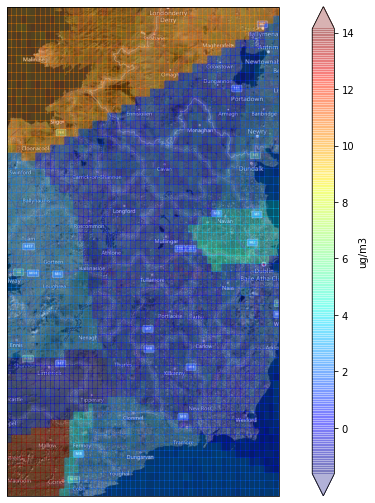

In [ ]:
utils.plotMap(pred,lon,lat,ireland_bound)

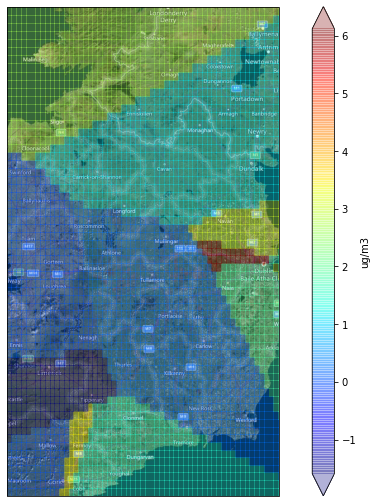

In [ ]:
utils.plotMap(true,lon,lat,ireland_bound)

# O<sub>3</sub>

In [ ]:
files = pd.read_csv("/content/O3dataset/files.csv").sample(frac=1).reset_index(drop=True)

In [ ]:
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=5,shuffle=True)
# files.loc[:,'Fold'] = -1

# for fold,(i_trn,i_val) in enumerate(kf.split(files)):
#   files.loc[i_val,"Fold"] = fold

# files.to_csv("files.csv",index=False)
# !rm -r "/content/O3dataset/files.csv"
# !cp "files.csv" "/content/O3dataset/files.csv"
# !kaggle datasets init -p "/content/O3dataset"
# _ = input("Press any Key to continue")
# !kaggle datasets version -p "/content/O3dataset" --dir-mode tar -m "Update"

In [ ]:
def loadData(df,satdir = "/content/O3dataset/satellite/",gdir = "/content/O3dataset/ground/"):
  X = []
  Y = []
  for i in range(df.shape[0]):
    factor = 46*(6.02214/6.023)*1e2
    sat = np.expand_dims(factor*np.load(os.path.join(satdir,df["SatFile"].iloc[i])),axis=2)      
    ground = np.load(os.path.join(gdir,df["GroundFile"].iloc[i])).flatten()
    if not np.isnan(np.sum(sat)) and not np.isnan(np.sum(ground)):
      if not np.std(ground)==0:
        X.append(sat)
        Y.append(ground)
  return np.stack(X,axis=0),np.stack(Y,axis=0)

In [ ]:
def build_model(X_train):
  inp = L.Input(shape=X_train[0].shape)
  h = L.Conv2D(16,(3,3),activation="linear",padding="same")(inp)
  h = L.Conv2D(16,(3,3),activation="linear")(h)
  h = L.MaxPooling2D(pool_size = (2,2),strides =2)(h)
  h = L.Conv2D(16,(3,3),activation="linear")(h)
  h = L.Conv2D(32,(3,3),activation="linear")(h)
  out = L.Flatten()(h)
  out = L.Dense(100,activation="linear")(out)
  out = L.Dense(np.prod(X_train[0].shape),activation="linear")(out)
  model = Model(inputs=inp,outputs=out)
  model.compile(optimizer=Adam(learning_rate=0.001),loss="mse",
                metrics=[RootMeanSquaredError()])
  
  return model

In [ ]:
scores_list = []
rmses = []
maes = []

for fold in range(5):
  print("\nFold {}\n".format(fold))
  train_files = files[files["Fold"]!=fold]
  val_files = files[files["Fold"]==fold]

  X_train,Y_train = loadData(train_files)
  X_val,Y_val = loadData(val_files)
  # loss_plt = utils.loss_plt()
  K.clear_session()
  model = build_model(X_train)
  if fold==0:
    print(model.summary())
  ckpt = ModelCheckpoint(f"model_{fold}.hdf5",monitor="val_root_mean_squared_error",mode="min",save_best_only=True,save_weights_only=True)
  model.fit(X_train,Y_train,
            epochs=50,
            verbose=0,
            batch_size=8,
            validation_data = (X_val,Y_val),
            callbacks=[ckpt])
  model.load_weights(f"model_{fold}.hdf5")
  rmse = mean_squared_error(Y_val,model.predict(X_val),squared=False)
  rmses.append(rmse)
  mae = mean_absolute_error(Y_val,model.predict(X_val))
  maes.append(mae)

  print("Fold {} RMSE Score: {}".format(fold, rmse))
  s,ls = pearsonCorrAvgDays(Y_val,model.predict(X_val))
  print("Fold {} Pearson coeff avg over days: {}".format(fold,np.mean([i for i in ls if not pd.isnull(i)])))
  scores_list.append(ls)
  if fold!=4:
    del model
    _ = gc.collect()
print("\nCV RMSE Score: {}".format(np.mean(rmses)))
print("\nCV MAE Score: {}".format(np.mean(maes)))


Fold 0

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 71, 86, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 71, 86, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 69, 84, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 42, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 40, 16)        2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 38, 32)        4640      
_________________________________________________________________
flatten (Flatten)            (None, 36480)          

In [ ]:
print("CV Pearson's average: {}".format(np.mean([0.7439213201405387,0.7100761715754187,0.7805399883720066,0.6821379225118326,0.7547959216875355])))

CV Pearson's average: 0.7342942648574665


In [ ]:
ireland_bound = [-10.3401, -6.022 ,51.828500000000005 , 55.422] #Irealand Extent
llcrn,urcrn = (-10.3401, 51.828500000000005),(-6.022, 55.422) # Ireland bounds
# llcrn,urcrn = (-6.37,53.282),(-6.11,53.47) # dublin bounds
num_cols = int((urcrn[0]-llcrn[0])//0.05)
num_rows = int((urcrn[1]-llcrn[1])//0.05)
lat_cords = np.linspace(llcrn[1],urcrn[1]+0.05,num_rows)
lon_cords = np.linspace(llcrn[0],urcrn[0]+0.05,num_cols)
lon,lat = np.meshgrid(lon_cords,lat_cords)

In [ ]:
pred = model.predict(np.stack([X_val[10]]))[0].reshape((X_train[0].shape[0],X_train[0].shape[1]))
true = Y_val[10].reshape((X_train[0].shape[0],X_train[0].shape[1]))

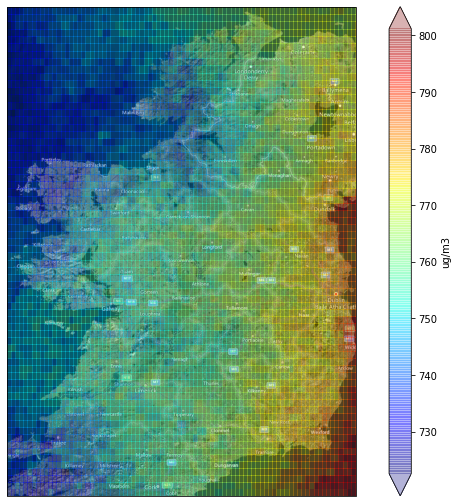

In [ ]:
utils.plotMap(X_val[0][:,:,0],lon,lat,ireland_bound)

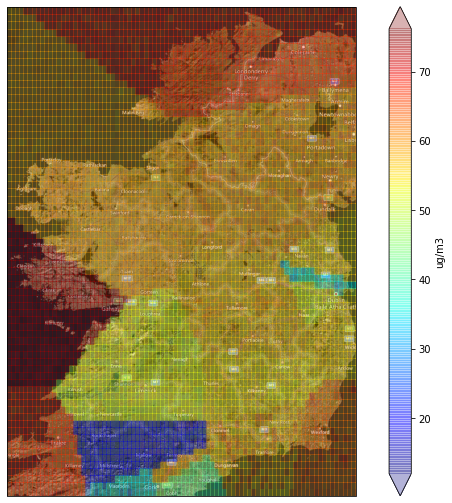

In [ ]:
utils.plotMap(pred,lon,lat,ireland_bound)

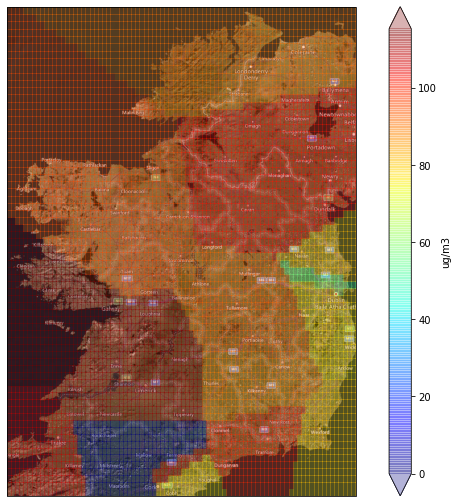

In [ ]:
utils.plotMap(true,lon,lat,ireland_bound)